# **Collaborative Filtering**

In [158]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession, Window, DataFrame, Row
from pyspark.sql.functions import (
    col, sqrt, sum as spark_sum, abs as spark_abs,
    when, row_number, lit, avg, pow, mean, desc, count,
    broadcast, collect_list, struct
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import (
    StructType, StructField, IntegerType, FloatType, DoubleType
)
from scipy.sparse import coo_matrix

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Khởi tạo SparkSession và đọc dữ liệu**

SparkSession được tạo với tên ứng dụng là "CollaborativeFiltering_Pearson".

Dữ liệu được đọc từ Google Drive với tùy chọn header=True để sử dụng dòng đầu làm tiêu đề, và inferSchema=True để tự động suy luận kiểu dữ liệu.

Chỉ giữ lại 3 cột: user, item và rating để phục vụ cho bài toán Collaborative Filtering.


In [137]:
# Khởi tạo session
spark = SparkSession.builder \
    .appName("CollaborativeFiltering") \
    .getOrCreate()

# **Dataset Description: `ratings2k.csv`**
**This dataset contains product rating information, with 2365 data samples and the following columns:**

| Column Name | Description             | Data Type | Example     |
|-------------|--------------------------|-----------|-------------|
| `index`     | Row index                | Integer   | 0, 1, 2...   |
| `user`      | User ID                  | String    | 73, 36, 72...  |
| `item`      | Product ID               | String    | 52, 239, 26...  |
| `rating`    | Rating (from 0.0 to 5.0) | Float     | 4, 3, 1...    |


In [136]:
DATA_PATH = '/content/drive/MyDrive/ratings2k.csv'

In [138]:
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

## **Algorithms**
Implement the Collaborative Filtering algorithm to recommend items for individual

users using PySpark. It should be a class for future deployment.
The similarity between users is measured using the Pearson correlation coefficient.

The constructor takes in the value of N (number of similar users) and the data set as a data frame (PySpark).

The function predict() takes in a user (a vector of ratings) and the expected number of recommended items. It returns a data frame (PySpark) consisting of recommended items sorted in the descending order of scores.

## **Experiments**
Load the given dataset to construct the utility matrix and then infer “profile” vectors for users and items.

Divide the dataset into a training and test sets with the ratio of 8 : 2.

Evaluate the algorithm in the test set with N in the range [2, 16]. After that, draw a bar chart to illustrate the RMSE values for each N.

## **Lớp `CollaborativeFiltering`: Dự đoán đánh giá bằng lọc cộng tác dựa trên Pearson**

Chuẩn hóa đánh giá để tính Pearson giữa người dùng.

Chọn Top-N người dùng tương tự nhất cho mỗi người dùng cần dự đoán.

Dự đoán đánh giá dựa trên đánh giá của hàng xóm có trọng số theo độ tương quan.

In [ ]:
class CollaborativeFiltering:
    def __init__(self, N, dataframe):
        self.N = N
        self.train = dataframe.cache()

        self.user_avg = self.train.groupBy("user") \
                           .agg(avg("rating").alias("avg_rating")).cache()

        self.train_norm = self.train.join(self.user_avg, "user") \
                             .withColumn("norm_rating", col("rating") - col("avg_rating")) \
                             .select("user", "item", "norm_rating") \
                             .cache()

    def _build_target_df(self, target_vector):
        spark = SparkSession.builder.getOrCreate()
        vals = [(i, float(r)) for i, r in target_vector.items()]
        return spark.createDataFrame(vals, ["item", "rating"])

    def predict(self, target_vector: dict, num_recommendations: int):
        spark = SparkSession.builder.getOrCreate()

        # Build target_df & tính avg, norm
        target_df = self._build_target_df(target_vector)
        target_avg = sum(target_vector.values()) / len(target_vector)
        target_norm = target_df.withColumn("target_norm", col("rating") - lit(target_avg))

        # Tính Pearson similarity
        joined = self.train_norm.join(target_norm, "item", "inner") \
            .withColumn("xx", col("norm_rating") * col("norm_rating")) \
            .withColumn("yy", col("target_norm") * col("target_norm")) \
            .withColumn("xy", col("norm_rating") * col("target_norm"))

        sim_df = joined.groupBy("user") \
            .agg(
              spark_sum("xy").alias("num_uv"),
              spark_sum("xx").alias("den_u"),
              spark_sum("yy").alias("den_v")
            ).withColumn(
              "similarity",
              when((col("den_u") * col("den_v")) != 0,
                   col("num_uv") / sqrt(col("den_u") * col("den_v")))
              .otherwise(lit(0.0))
            ).select("user", "similarity")

        # Lấy tất cả bình luận đã normalized, join với similarity
        cand = self.train_norm.join(sim_df, "user") \
            .select("user", "item", "norm_rating", "similarity")

        # Loại bỏ các item đã đánh giá trong target_vector
        #    Tạo DataFrame các item đã đánh giá
        rated = spark.createDataFrame(
            [(i,) for i in target_vector.keys()], ["item"]
        )
        cand = cand.join(rated, on="item", how="left_anti")

        # Tính weighted và abs_sim, groupBy item để aggregate
        cand = cand.withColumn("weighted", col("norm_rating") * col("similarity")) \
                   .withColumn("abs_sim", spark_abs(col("similarity")))

        agg = cand.groupBy("item").agg(
            spark_sum("weighted").alias("numerator"),
            spark_sum("abs_sim").alias("denominator")
        )

        # Tính score và chọn top N
        result = agg.withColumn(
            "score",
            when(col("denominator") != 0,
                 lit(target_avg) + col("numerator")/col("denominator"))
            .otherwise(lit(0.0))
        ).select("item", "score") \
         .orderBy(col("score").desc()) \
         .limit(num_recommendations)

        return result


### **Hàm `compute_rmse`: Đánh giá mô hình bằng RMSE**
Tính sai số căn phương bình phương trung bình (Root Mean Squared Error – RMSE) giữa giá trị dự đoán và thực tế.

In [150]:
def calculate_rmse_results(collab, test_data, min_n=2, max_n=17):
    spark = SparkSession.builder.getOrCreate()
    evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="true_rating",
        predictionCol="prediction"
    )

    # Tính global Pearson similarity cho mọi cặp user ---
    a = collab.train_norm.alias("a")  # (user, item, norm_rating)
    b = collab.train_norm.alias("b")

    pairs = (
        a.join(b, on="item")
         .filter(col("a.user") < col("b.user"))
         .select(
             col("a.user").alias("u"),
             col("b.user").alias("v"),
             (col("a.norm_rating") * col("b.norm_rating")).alias("xy"),
             (col("a.norm_rating") * col("a.norm_rating")).alias("xx"),
             (col("b.norm_rating") * col("b.norm_rating")).alias("yy")
         )
    )

    sim = (
        pairs.groupBy("u", "v")
             .agg(
                 spark_sum("xy").alias("num"),
                 spark_sum("xx").alias("den1"),
                 spark_sum("yy").alias("den2")
             )
             .withColumn(
                 "similarity",
                 when((col("den1") * col("den2")) != 0,
                      col("num") / sqrt(col("den1") * col("den2")))
                 .otherwise(lit(0.0))
             )
             .select(
                 col("u").alias("user"),
                 col("v").alias("neighbor"),
                 "similarity"
             )
    )
    # Thêm cặp ngược lại để hoàn chỉnh
    sim_rev = sim.select(
        col("neighbor").alias("user"),
        col("user").alias("neighbor"),
        "similarity"
    )
    sim_df = sim.union(sim_rev).cache()

    results = []
    # Với mỗi N, tính RMSE
    for N in range(min_n, max_n):
        # Chọn top-K neighbors cho mỗi user
        w = Window.partitionBy("user").orderBy(col("similarity").desc())
        topK = (
            sim_df
            .withColumn("rank", row_number().over(w))
            .filter(col("rank") <= N)
            .drop("rank")
        )

        # Join test_data với topK và train_norm để lấy norm_rating
        joined = (
            test_data.alias("t")
                     .join(topK.alias("s"), col("t.user") == col("s.user"))
                     .join(
                         collab.train_norm.alias("r"),
                         (col("s.neighbor") == col("r.user")) &
                         (col("t.item") == col("r.item"))
                     )
                     .select(
                         col("t.user").alias("target_user"),
                         col("t.item").alias("target_item"),
                         col("t.rating").alias("true_rating"),
                         col("s.similarity"),
                         col("r.norm_rating")
                     )
        )

        # Tính prediction = Σ(similarity * norm_rating) / Σ|similarity|
        pred = (
            joined
            .withColumn("weighted", col("similarity") * col("norm_rating"))
            .groupBy("target_user", "target_item", "true_rating")
            .agg(
                spark_sum("weighted").alias("weighted_sum"),
                spark_sum(spark_abs(col("similarity"))).alias("sim_sum")
            )
            .withColumn(
                "prediction",
                when(col("sim_sum") > 0, col("weighted_sum") / col("sim_sum"))
                .otherwise(lit(0.0))
            )
        )

        rmse = evaluator.evaluate(pred)
        results.append((N, rmse))

    return results


### **Trực quan hóa mối quan hệ giữa số hàng xóm (N) và sai số RMSE**

In [151]:
def plot_rmse_results(rmse_results):
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(
        [result[0] for result in rmse_results],
        [result[1] for result in rmse_results],
        width=0.6,
        color='skyblue',
        edgecolor='navy',
        alpha=0.8
    )

    ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
    ax.set_axisbelow(True)

    ax.set_xlabel("N", fontsize=12, fontweight='bold')
    ax.set_ylabel("RMSE", fontsize=12, fontweight='bold')
    ax.set_title("RMSE for Different N Values", fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks([result[0] for result in rmse_results])
    ax.tick_params(axis='both', which='major', labelsize=10)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3),
                ha='center', va='bottom', fontsize=9, color='black')

    plt.tight_layout()
    plt.savefig("rmse_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

In [155]:
def get_user_vector(user_id, dataframe):
    rows = dataframe.filter(col("user") == user_id).select("item", "rating").collect()
    return {row["item"]: row["rating"] for row in rows}

# **Test**

In [153]:
spark = SparkSession.builder.appName("UserBasedCF").getOrCreate()
data = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

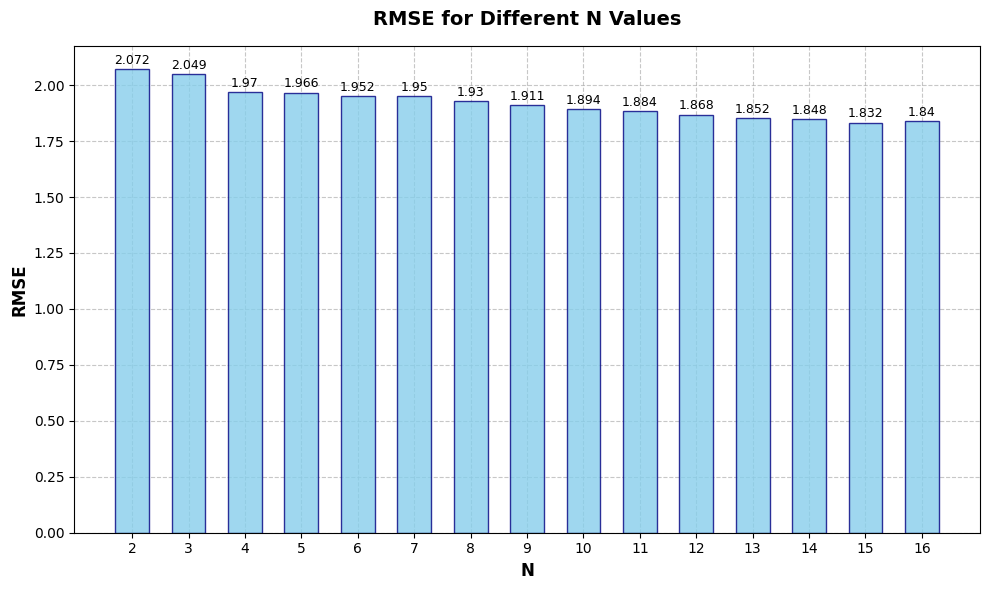

In [ ]:
collab = CollaborativeFiltering(N=8, dataframe=train_data)
rmse_results = calculate_rmse_results(collab, test_data)
plot_rmse_results(rmse_results)


In [ ]:
# Khởi tạo Collaborative Filtering
collab = CollaborativeFiltering(N=10, dataframe=train_data)

# Danh sách user cần dự đoán
user_test = [1, 20, 50, 70]

for user_id in user_test:
    user_vector = get_user_vector(user_id, train_data)
    if len(user_vector) == 0:
        print(f"User {user_id} không có đánh giá trong tập huấn luyện.")
        continue

    recommendations = collab.predict(user_vector, num_recommendations=20)
    print(f"\nTop 5 recommendations for user {user_id}:")
    recommendations.show(5, truncate=False)



Top 5 recommendations for user 1:
+----+-----------------+
|item|score            |
+----+-----------------+
|94  |7.4              |
|431 |6.187878787878788|
|99  |6.187878787878788|
|183 |5.715789473684211|
|391 |5.715789473684211|
+----+-----------------+
only showing top 5 rows


Top 5 recommendations for user 20:
+----+-----------------+
|item|score            |
+----+-----------------+
|336 |7.292857142857143|
|111 |6.934210526315789|
|99  |6.037878787878788|
|431 |6.037878787878788|
|64  |5.934210526315789|
+----+-----------------+
only showing top 5 rows


Top 5 recommendations for user 50:
+----+-----------------+
|item|score            |
+----+-----------------+
|242 |7.125821596244132|
|313 |6.446153846153846|
|429 |6.15             |
|296 |6.125821596244132|
|252 |6.125821596244132|
+----+-----------------+
only showing top 5 rows


Top 5 recommendations for user 70:
+----+-----------------+
|item|score            |
+----+-----------------+
|336 |6.140079365079366|
|111 |5

# **Dừng Spark**

In [157]:
spark.stop()